Ивент-анализ — инструмент, используемый в политических исследованиях, как правило, для анализа сложных политических процессов, в которых задействовано несколько участников. Задача нашей работы состояла в определении уровня конфликтности-согласия среди стран и международных организаций, вовлекающихся в события вокруг Специальной военной операции, проводимой Россией на Украине на протяжении трех лет. Информационной базой для анализа служат новостные сообщения медиа-ресурсов. Для каждого сообщения необходимо определить задействованных в нем участников и интенсивность вида, описанного действия. Для определения вида интенсивности была использована LDA модель, которая способствовала выделению 67 тем и далее, используя их, было присвоена определенная тема каждой новостию

#Парсер данных

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
from datetime import datetime
import threading
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import date, timedelta
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from bs4 import BeautifulSoup

In [ ]:
chrome_driver_path = 'chromedriver.exe'
chrome_options = Options()
service = Service(executable_path=chrome_driver_path)
driver = webdriver.Chrome()

In [ ]:
all_news = []
# Задаем начальную дату
start_date = date(2022, 2, 25)
# И конечную дату
end_date = date(2025, 3, 25)
current_date = start_date



try:
  while current_date <= end_date:

    # Формируем URL
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://www.kommersant.ru/archive/theme/3423/day/{date_str}"
    # Загружаем страницу
    driver.get(url)
    while True:
        try:
            button_locators = (By.CLASS_NAME, "js-archive-more-button") #  замените на нужный вам класс
            buttons = driver.find_elements(*button_locators)
            flag = False
            for btn in buttons:
                if btn.text == ' Показать еще ':
                    driver.execute_script("arguments[0].scrollIntoView();", btn)
                    btn[0].click()
                    time.sleep(2)
                    ok = True
            if not flag:
                break
        except Exception as x:
            print("Кнопка обрабатывается. Подождите...")
    print(f"Processing news for {current_date}")
    try:
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # Получаем все новости
        news_list = soup.find_all('article')
        if not news_list:
            print(f"No news for {current_date}")
            continue

        for news in news_list:
            try:
                # Извлечение ссылки из атрибута data-article-url
                news_url = news.get('data-article-url')
                if not news_url:
                     news_url = "Ссылка не найдена"
                # Извлечение заголовка из атрибута data-article-title
                news_title = news.get('data-article-title')
                if not news_title:
                     news_title = "Заголовок не найден"
                # Извлечение даты из тега
                news_description = news.get('data-article-description')
                if not news_description:
                     news_description = "Описание не найдено не найден"
                date_element = news.find('p', class_="uho__tag")
                if date_element:
                   news_date = date_element.text.strip()
                else:
                  news_date = "Дата не найдена"

                # Извлечение тегов
                tag_elements = news.find_all('a', class_="tag_list__link")
                tags = [tag.text.strip() for tag in tag_elements]

                article_data = {
                 "url": news_url,
                 "description": news_description,
                 "title": news_title,
                 "date": news_date,
                  "tags": tags
                }
                all_news.append(article_data)
            except Exception as e:
                print(f"An error occurred while processing one news: {e}")

    except TimeoutException:
            print(f"Timeout while loading page for {current_date}")
    except Exception as e:
            print(f"An unexpected error occurred: {e}")

    current_date += timedelta(days=1)

except Exception as e:
     print(f"An error occurred: {e}")
finally:
    driver.quit()

In [ ]:
filename = 'news_svo_v3.xlsx'
df = pd.DataFrame(all_news)
df.to_excel(filename, index=False)  # index=False убирает столбец с индексами
print(f"Data saved to {filename}")

In [ ]:
len(all_news)

# Импортирование библиотек

In [81]:
# !pip install gensim

In [82]:
# !pip install numpy==1.24.0

In [145]:
import pandas as pd

In [146]:
import gensim

In [147]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats


from gensim.models.ldamulticore import LdaMulticore
import gensim
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
#from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Подготовка данных

Ранее данных, которые были взяты с сайта, были сохранены. Загрузим их

In [148]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
path = '/content/drive/MyDrive/коммерсант.xlsx'

In [150]:
df = pd.read_excel(path)

In [151]:
df.drop('url', axis=1, inplace = True)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19023 entries, 0 to 19022
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  19023 non-null  object
 1   title        19023 non-null  object
 2   date         19023 non-null  object
 3   tags         19023 non-null  object
dtypes: object(4)
memory usage: 594.6+ KB


Преобразование даты, извлечение

In [153]:
df['date'] = pd.to_datetime(df['date'])

<ipython-input-153-e8d2d516eb0e>:1: UserWarning: Parsing dates in %d.%m.%Y, %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [154]:
df['year'] = df['date'].dt.strftime('%Y')
df['month'] = df['date'].dt.strftime('%m')
df['day'] = df['date'].dt.strftime('%d')

In [155]:
df.drop('date', axis=1, inplace = True)

 Объединяет описание и заголовок в один столбец по условию.

In [156]:
def combine_description_title(row):
    """
    Объединяет описание и заголовок в один столбец по условию.
    Если описание равно "Описание не найдено", берем заголовок, иначе - описание.
    """
    if row['description'] == "Описание не найдено не найден":
        return row['title']
    else:
        return row['description']

In [157]:
df['info_new'] = df.apply(combine_description_title, axis=1)

In [158]:
df.drop('description', axis=1, inplace = True)
df.drop('tags', axis=1, inplace = True)

Также необходимо привести предложения к общему формату.

In [159]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower().strip()
    # Удаление HTML-тегов
    text = re.sub('<[^>]+>', '', text)
    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    # Удаление пробелов
    text = text.strip()

    return text

In [160]:
df['info_new'] = df['info_new'].apply(preprocess_text)

Токинизируем

In [161]:
nltk.download('punkt_tab')
df['info_new'] = df['info_new'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Удалим стоп-слова

In [162]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('russian'))
    return [word for word in tokens if word not in stop_words]

In [163]:
df['info_new'] = df['info_new'].apply(remove_stopwords)

Лемматизация

In [164]:
from nltk.stem.snowball import SnowballStemmer

In [165]:
nltk.download('punkt') #Если вы еще не скачали punkt

stemmer = SnowballStemmer("russian")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [166]:
df['info_new'] = df['info_new'].apply(lambda sentence: [stemmer.stem(word) for word in sentence])

In [167]:
df['tokens'] = df['info_new'].apply(lambda word: ' '.join(word))

In [168]:
df

,title,year,month,day,info_new,tokens
0,МИД РФ заявил об отказе Украины от переговоров...,2022,02,25,"[мид, рф, заяв, отказ, украин, переговор, вопр...",мид рф заяв отказ украин переговор вопрос обсу...
1,Абхазия признала ДНР и ЛНР,2022,02,25,"[абхаз, призна, днр, лнр]",абхаз призна днр лнр
2,Госдеп о санкциях против Путина: все варианты ...,2022,02,25,"[госдеп, санкц, прот, путин, вариант, рассматр...",госдеп санкц прот путин вариант рассматрива
3,Песенный ущерб,2022,02,25,"[росс, поедет, евровиден]",росс поедет евровиден
4,"Ложь, фейк и видео",2022,02,25,"[обществен, палат, рассортирова, недостоверн, ...",обществен палат рассортирова недостоверн инфор...
...,...,...,...,...,...,...
19018,За ночь силы ПВО уничтожили один беспилотник,2025,01,25,"[ноч, сил, пво, уничтож, беспилотник]",ноч сил пво уничтож беспилотник
19019,В Курске прошло первое заседание совета по воп...,2025,01,25,"[курск, прошл, перв, заседан, совет, вопрос, п...",курск прошл перв заседан совет вопрос переселенц
19020,Над тремя регионами сбили 15 беспилотников,2025,01,26,"[трем, регион, сбил, беспилотник]",трем регион сбил беспилотник
19021,Губернатор Рязанской области сообщил о работе ПВО,2025,01,26,"[губернатор, рязанск, област, сообщ, работ, пво]",губернатор рязанск област сообщ работ пво


In [169]:
df['word_list'] = df['tokens'].str.split()

In [170]:
df

,title,year,month,day,info_new,tokens,word_list
0,МИД РФ заявил об отказе Украины от переговоров...,2022,02,25,"[мид, рф, заяв, отказ, украин, переговор, вопр...",мид рф заяв отказ украин переговор вопрос обсу...,"[мид, рф, заяв, отказ, украин, переговор, вопр..."
1,Абхазия признала ДНР и ЛНР,2022,02,25,"[абхаз, призна, днр, лнр]",абхаз призна днр лнр,"[абхаз, призна, днр, лнр]"
2,Госдеп о санкциях против Путина: все варианты ...,2022,02,25,"[госдеп, санкц, прот, путин, вариант, рассматр...",госдеп санкц прот путин вариант рассматрива,"[госдеп, санкц, прот, путин, вариант, рассматр..."
3,Песенный ущерб,2022,02,25,"[росс, поедет, евровиден]",росс поедет евровиден,"[росс, поедет, евровиден]"
4,"Ложь, фейк и видео",2022,02,25,"[обществен, палат, рассортирова, недостоверн, ...",обществен палат рассортирова недостоверн инфор...,"[обществен, палат, рассортирова, недостоверн, ..."
...,...,...,...,...,...,...,...
19018,За ночь силы ПВО уничтожили один беспилотник,2025,01,25,"[ноч, сил, пво, уничтож, беспилотник]",ноч сил пво уничтож беспилотник,"[ноч, сил, пво, уничтож, беспилотник]"
19019,В Курске прошло первое заседание совета по воп...,2025,01,25,"[курск, прошл, перв, заседан, совет, вопрос, п...",курск прошл перв заседан совет вопрос переселенц,"[курск, прошл, перв, заседан, совет, вопрос, п..."
19020,Над тремя регионами сбили 15 беспилотников,2025,01,26,"[трем, регион, сбил, беспилотник]",трем регион сбил беспилотник,"[трем, регион, сбил, беспилотник]"
19021,Губернатор Рязанской области сообщил о работе ПВО,2025,01,26,"[губернатор, рязанск, област, сообщ, работ, пво]",губернатор рязанск област сообщ работ пво,"[губернатор, рязанск, област, сообщ, работ, пво]"


Необходимо присводить категорию (для выделений объектов ключевых)

In [171]:
categories = {
    'Россия': ['росс','прифронтов','рэб','делимхан','госсайт','минкульт','транснефт','симферопол', 'рогозин','плен', 'осколочн','крылат','борисовк','армавир', 'калуг','миннихан','матвиенк','милон','пермяк','минэкономик', 'эсер','новосибирск','челябинск','фссп','госуслуг', 'фом','санкц','нафтогаз','клишас','референдум', 'петербуржц','горин','грызл','мединск','фейк', 'росатом','погибл', 'мвд','генштаб', 'гурул', 'хуснуллин', 'росгвард', 'устьилимск', 'басма', 'сальд', 'прилепин', 'бахмут', 'минобрнаук', 'пригожин', 'совфед', 'генпрокурор', 'цво', 'сафронов',  'турчак', 'иркутск', 'минстро', 'курмояров', 'балицк', 'кравц', 'лукойл', 'кубинк', 'парнас', 'сызранск', 'туапс', 'железногорск', 'минэнерг', 'нижегородск',  'клинц', 'черноморск', 'феодос', 'рособрнадзор', 'чемез', 'егэ', 'кагарлицк', 'ростех',  'скр', 'бекмурад', 'присоединен', 'патруш', 'мантур', 'любимов', 'урал', 'минздра', 'хма', 'чонгарск', 'симонья', 'брянщин', 'шойг', 'вагнер',  'вихр', 'ленобласт', 'славянск', 'таволжанк', 'уралвагонзавод', 'забайкал', 'ставропол', 'агробелогор', 'фсин','захарченк', 'вороб', 'гд', 'балаших', 'анап', 'мид', 'новосибирец', 'алушт', 'ясиноват', 'пасечник', 'иноагент', 'столичн',  'обстрел', 'черемошн', 'макеевк', 'дронакамикадз', 'петербуржец', 'красноярск', 'минцифр', 'выплат', 'нлмк', 'врачиволонтер', 'бурят', 'авдеевк', 'краматорск', 'заэс', 'мелитопол', 'тасс', 'судж', 'лисичанск', 'керч', 'льгов', 'сахалин', 'тверск', 'гладк', 'кремл', 'поддубн', 'аксен', 'тихорецк', 'калужск', 'минтруд', 'владивосток', 'пушилин', 'адыг', 'алаудин', 'буянов', 'пригранич', 'алт', 'нижегородц', 'буянов', 'картапол', 'каспийск', 'примор', 'рыльск', 'махачкал', 'хинштейн', 'горинов', 'фсб', 'подмосков','рпц', 'мчс', 'москальков', 'владикавказ', 'военноплен', 'москальков', 'каховк', 'таганрог', 'горловк', 'белоус', 'энгельс', 'татарста', 'рашник', 'срзп', 'дриз', 'telegram', 'серебренников', 'mir', 'z', 'v', 'удмурт', 'сво', 'чулпа', 'сбер', 'росбанк', 'спецоперац', 'росавиац', 'пермск', 'энергодар', 'аэрофлот', 'скочиленк', 'пискар', 'карпин', 'генпрокуратур', 'жебел', 'уралкал', 'лавр', 'цб', 'рбк', 'минпромторг', 'сбербанк', 'альфабанк', 'кадыр', 'дерипаск', 'русск', 'рубл', 'минфин', 'басурин', 'минтранс', 'госдум', 'абрамович', 'бердянск', 'донбасс', 'дискредитац', 'силуан', 'российск', 'северста', 'газпр', 'мосбирж', 'мариупол', 'вс', 'миноборон', 'смоленск', 'калининградск','совкомбанк', 'белгородск', 'дондонбасс', 'рф', 'роснефт', 'госизмен', 'медвед', 'беспилотник', 'санктпетербургск','ростовск', 'воронежск', 'саратовск', 'пво', 'втб', 'рязанск', 'роскомнадзор', 'минобороны','мишустин', 'москв', 'собянин', 'путин', 'песков', 'лавров', 'володин', 'захаров', 'небензя', 'кадыров', 'гладков', 'шойгу', 'герасимов', 'белоусов', 'воронеж', 'курск', 'петербург', 'ленинград', 'днр', 'лнр', 'херсон', 'запорож', 'донецк', 'луганск', 'белгород', 'саратов', 'астрахан', 'мурманск', 'казан', 'татарстан', 'чечен', 'чечн', 'ростов', 'краснодар', 'крым', 'севастопол', 'алтай', 'брянск', 'владимир', 'волгоград', 'иванов', 'калининград', 'киров', 'курган', 'липецк', 'новгород', 'оренбург', 'омск', 'пензен', 'псков', 'рязан', 'самар', 'свердловск', 'екатеринбург', 'тамбов', 'тульск', 'ярославл'],
    'Украина': ['украин', 'плен','осколочн','рэб','николаев','крылат', 'подоляк', 'рад', 'будан','укрэнерг', 'погибл', 'опзж', 'atacms', 'himars', 'балицк', 'дерусифицирова', 'изюм', 'львов', 'приватбанк', 'буданов', 'бабел', 'днепр', 'чонгарск', 'харьков', 'конотоп', 'сбу', 'заэс', 'обстрел', 'дронакамикадз', 'atacms', 'обстрелива', 'артобстрел', 'военноплен', 'снбо', 'кассетн', 'бпла', 'верховн', 'чернобыльск', 'ки', 'киев', 'зеленск', 'мариупол', 'залужн', 'беспилотник', 'кулеб', 'всу', 'житомир', 'винниц', 'чернигов', 'сумск', 'ровн', 'ивано-франковск', 'одесс', 'полтав', 'хмельницк', 'кировоград', 'закарпат', 'волын', 'черкасск', 'тернопол'],
    'Дружественные страны': ['абхаз', 'вучич','мюнхенск', 'тегера', 'эрдога', 'анкар', 'босфор', 'белорусс', 'лукашенк', 'алжир', 'аргентин', 'афган', 'бахрейн', 'беларус', 'лукашенко', 'минск', 'герцеговин', 'боснийск', 'бразил', 'венесуэл', 'мадуро', 'брикс', 'вьетнам', 'египет', 'зимбабве', 'израил', 'индия', 'индийск', 'индус', 'индонез', 'иордан', 'ирак', 'иран', 'кения', 'кенийск', 'китай', 'кндр', 'коста-рика', 'кувейт', 'лесото', 'ливан', 'маврикий', 'мадагаскар', 'малайз', 'мальдив', 'марокко', 'мозамбик', 'африк', 'молдав', 'монгол', 'мьянм', 'намиб', 'никарагуа', 'оман', 'пакистан', 'саудовск', 'сейшел', 'серби', 'сербск', 'сирия', 'сирий', 'таиланд', 'танзан', 'тунис', 'турц', 'турец', 'Эрдоган', 'стамбул', 'уругвай', 'фиджи', 'филлипин', 'шри-ланк', 'эфиоп', 'юар'],
    'Недружественные страны': ['американск','орба','спч', 'мюнхенск','клинтон','немецк','еврокомисс', 'санкц', 'урсул', 'бербок', 'боррел','рамштайн', 'альянс', 'youtube', 'словак', 'android', 'kinross', 'gold', 'royal', 'польск', 'эйфелев', 'atacms', 'himars', 'берлин', 'блинк',  'иностра', 'google', 'meta', 'париж', 'европ', 'airlines', 'нат', 'американц', 'байд', 'австрали', 'албан', 'андорр', 'багам', 'британ', 'англ', 'Трасс', 'джонсон', 'даунинг-стрит', 'ес', 'запад', 'европейск', 'евросоюз', 'европа', 'нато', 'исланд', 'канад', 'лихтенштейн', 'микронез', 'монак', 'зеланд', 'норвег', 'сан-марин', 'македон', 'сингапур', 'америк', 'сша', 'пентагон', 'байден', 'трамп', 'тайван', 'черногор', 'швейцар', 'япон', 'австри', 'бельг', 'болгар', 'герман', 'фрг', 'шольц', 'Бербок', 'грец', 'датск', 'дания', 'ирланд', 'испан', 'итал', 'кипр', 'латв', 'литв', 'прибалт', 'люксембург', 'мальт', 'нидерланд', 'голланд', 'польш', 'португал', 'румын', 'словен', 'финлянд', 'франц', 'Макрон', 'Хорват', 'чехи', 'чешск', 'швец', 'шведск', 'эстон', 'венгр', 'орбан'],
    'Нейтральные страны': ['азербайджан', 'римск', 'вто', 'ватика', 'международн', 'магатэ', 'казахста', 'ангол', 'оон', 'барбуд', 'армен', 'Пашинян', 'бангладеш', 'барбадос', 'белиз', 'бенин', 'болив', 'бруней', 'вануату', 'тимор', 'габон', 'гайан', 'гамби', 'гватемал', 'гвинейск', 'гвинея', 'гренада', 'грузинск', 'грузия', 'джибути', 'доминик', 'замби', 'йемен', 'кабо-вербе', 'казахстан', 'Токаев', 'камбодж', 'камерун', 'катар', 'кирабат', 'колумб', 'коморск', 'конго', 'косово', 'ивуар', 'куба', 'кубинск', 'кыргыстан', 'киргиз', 'лаос', 'либер', 'ливия', 'ливийск', 'мавритан', 'малави', 'маршаллов', 'мексика', 'мексиканск', 'науру', 'непал', 'нигер', 'оаэ', 'эмират', 'палау', 'панама', 'парагвай', 'руанда', 'сальвадор', 'самоа', 'принсипи', 'сенегал', 'сент-винсент', 'сент-китс', 'судан', 'сомали', 'суринам', 'таджикистан', 'тонго', 'тринидад', 'туркменистан', 'туркмения', 'туркменск', 'Уганда', 'Узбекистан', 'Узбекск', 'ЦАР', 'Чад', 'чили', 'эквадор']
}

In [172]:
def detect_categories_in_sentence(sentence, categories):
    tokens = word_tokenize(sentence.lower())

    matched_categories = set()
    for category, keywords in categories.items():
        for keyword in keywords:
            if any(keyword in token for token in tokens):
                matched_categories.add(category)
                break
    if not matched_categories:
        matched_categories.add("Не определено")
    return list(matched_categories)

# Применение к DataFrame
df['categories'] = df['tokens'].apply(lambda x: detect_categories_in_sentence(x, categories))

In [173]:
len(df[df['categories'].apply(lambda x: 'Не определено' in x)])

947

In [174]:
with pd.option_context('display.max_colwidth', None, 'display.width', 20000):
  print(df[df['categories'].apply(lambda x: 'Не определено' in x)]['word_list'].head(10))

32          [кана, пятниц, закр, орел, решк, антивоен, высказыван, продюсер, программ]
94                                                                         [видеофакт]
235                                                       [издател, прос, господдержк]
237                                            [компан, хвата, денег, партнер, техник]
335                                                              [прошл, митинг, март]
340    [сотрудниц, перв, кана, ворва, прям, эфир, антивоен, плакат, составл, протокол]
362                                                        [коридор, серьезн, договор]
364                                   [редактор, телекана, суд, оштрафова, высказыван]
419                                                                    [март, четверг]
617                                   [онлайнтрансляц, последн, новост, заявлен, март]
Name: word_list, dtype: object


Остальные строки не несут в себе важной информации, поэтому были удалены

In [175]:
df = df[df['categories'].apply(lambda x: 'Не определено' not in x)]

In [176]:
df['categories'].value_counts()

,count
categories,
"[Россия, Украина]",4118
"[Недружественные страны, Россия, Украина]",3560
[Россия],2892
"[Недружественные страны, Украина]",2294
"[Недружественные страны, Россия]",1905
[Украина],1118
[Недружественные страны],353
"[Россия, Украина, Нейтральные страны]",312
"[Россия, Дружественные страны, Украина]",262


Сохраняем обработанный файл

In [177]:
# df.to_csv('fominas_final3.csv', index=False)

In [178]:
# df = pd.read_csv('fominas_final3.csv')

In [179]:
df

,title,year,month,day,info_new,tokens,word_list,categories
0,МИД РФ заявил об отказе Украины от переговоров...,2022,02,25,"[мид, рф, заяв, отказ, украин, переговор, вопр...",мид рф заяв отказ украин переговор вопрос обсу...,"[мид, рф, заяв, отказ, украин, переговор, вопр...","[Россия, Украина]"
1,Абхазия признала ДНР и ЛНР,2022,02,25,"[абхаз, призна, днр, лнр]",абхаз призна днр лнр,"[абхаз, призна, днр, лнр]","[Россия, Дружественные страны]"
2,Госдеп о санкциях против Путина: все варианты ...,2022,02,25,"[госдеп, санкц, прот, путин, вариант, рассматр...",госдеп санкц прот путин вариант рассматрива,"[госдеп, санкц, прот, путин, вариант, рассматр...","[Недружественные страны, Россия]"
3,Песенный ущерб,2022,02,25,"[росс, поедет, евровиден]",росс поедет евровиден,"[росс, поедет, евровиден]",[Россия]
4,"Ложь, фейк и видео",2022,02,25,"[обществен, палат, рассортирова, недостоверн, ...",обществен палат рассортирова недостоверн инфор...,"[обществен, палат, рассортирова, недостоверн, ...","[Недружественные страны, Украина]"
...,...,...,...,...,...,...,...,...
19018,За ночь силы ПВО уничтожили один беспилотник,2025,01,25,"[ноч, сил, пво, уничтож, беспилотник]",ноч сил пво уничтож беспилотник,"[ноч, сил, пво, уничтож, беспилотник]","[Недружественные страны, Россия, Украина]"
19019,В Курске прошло первое заседание совета по воп...,2025,01,25,"[курск, прошл, перв, заседан, совет, вопрос, п...",курск прошл перв заседан совет вопрос переселенц,"[курск, прошл, перв, заседан, совет, вопрос, п...","[Недружественные страны, Россия]"
19020,Над тремя регионами сбили 15 беспилотников,2025,01,26,"[трем, регион, сбил, беспилотник]",трем регион сбил беспилотник,"[трем, регион, сбил, беспилотник]","[Недружественные страны, Россия, Украина]"
19021,Губернатор Рязанской области сообщил о работе ПВО,2025,01,26,"[губернатор, рязанск, област, сообщ, работ, пво]",губернатор рязанск област сообщ работ пво,"[губернатор, рязанск, област, сообщ, работ, пво]","[Недружественные страны, Россия]"


# MODEL

In [181]:
X1 = df['word_list']

In [182]:
dictionary = gensim.corpora.Dictionary(X1)

In [183]:
print(len(dictionary))

10429


In [184]:
# Check word frequencies in the corpus
freqs = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)

# Print the sorted output
for word_id, frequency in freqs[:10]:
    print(f"Word: {dictionary[word_id]}, Frequency: {frequency}")

Word: украин, Frequency: 5776
Word: росс, Frequency: 2269
Word: област, Frequency: 2146
Word: всу, Frequency: 1120
Word: сообщ, Frequency: 1119
Word: воен, Frequency: 1085
Word: сша, Frequency: 1043
Word: зеленск, Frequency: 944
Word: обстрел, Frequency: 940
Word: путин, Frequency: 916


In [185]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)

In [186]:
print(len(dictionary))

1420


In [187]:
bow_corpus = [dictionary.doc2bow(doc) for doc in X1]

In [188]:
print(bow_corpus[4330])
print([(dictionary[id], freq) for id, freq in bow_corpus[4330]])
print(X1[4330])

[(106, 1), (314, 1), (317, 2)]
[('стал', 1), ('снов', 1), ('геро', 2)]
['лукашенк', 'объяв', 'включен', 'все', 'арм', 'белорусс', 'региональн', 'группировк', 'войск', 'росс']


In [191]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=76,
                                       id2word = dictionary,
                                       passes = 20)

Сопостоавляем нужный класс со строчкой

In [192]:
def get_dominant_topic(bow, lda_model):
    """
    Определяет наиболее вероятную тему для документа.

    Args:
        bow: Bag-of-words представление документа.
        lda_model: Обученная LDA модель.

    Returns:
        tuple: (Номер темы, Вероятность).
    """
    topic_probabilities = lda_model.get_document_topics(bow) # Получаем вероятности тем для документа
    # Находим тему с максимальной вероятностью
    dominant_topic = sorted(topic_probabilities, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic

# Применяем функцию к каждому документу в bow_corpus
df['dominant_topic'] = [get_dominant_topic(bow, lda_model)[0] for bow in bow_corpus]

# [Дополнительно] Добавляем столбец с вероятностью темы
df['topic_probability'] = [get_dominant_topic(bow, lda_model)[1] for bow in bow_corpus]

<ipython-input-192-c679df623557>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = [get_dominant_topic(bow, lda_model)[0] for bow in bow_corpus]
<ipython-input-192-c679df623557>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_probability'] = [get_dominant_topic(bow, lda_model)[1] for bow in bow_corpus]


In [193]:
df

,title,year,month,day,info_new,tokens,word_list,categories,dominant_topic,topic_probability
0,МИД РФ заявил об отказе Украины от переговоров...,2022,02,25,"[мид, рф, заяв, отказ, украин, переговор, вопр...",мид рф заяв отказ украин переговор вопрос обсу...,"[мид, рф, заяв, отказ, украин, переговор, вопр...","[Россия, Украина]",14,0.290994
1,Абхазия признала ДНР и ЛНР,2022,02,25,"[абхаз, призна, днр, лнр]",абхаз призна днр лнр,"[абхаз, призна, днр, лнр]","[Россия, Дружественные страны]",38,0.503289
2,Госдеп о санкциях против Путина: все варианты ...,2022,02,25,"[госдеп, санкц, прот, путин, вариант, рассматр...",госдеп санкц прот путин вариант рассматрива,"[госдеп, санкц, прот, путин, вариант, рассматр...","[Недружественные страны, Россия]",10,0.287598
3,Песенный ущерб,2022,02,25,"[росс, поедет, евровиден]",росс поедет евровиден,"[росс, поедет, евровиден]",[Россия],0,0.013158
4,"Ложь, фейк и видео",2022,02,25,"[обществен, палат, рассортирова, недостоверн, ...",обществен палат рассортирова недостоверн инфор...,"[обществен, палат, рассортирова, недостоверн, ...","[Недружественные страны, Украина]",75,0.503289
...,...,...,...,...,...,...,...,...,...,...
19018,За ночь силы ПВО уничтожили один беспилотник,2025,01,25,"[ноч, сил, пво, уничтож, беспилотник]",ноч сил пво уничтож беспилотник,"[ноч, сил, пво, уничтож, беспилотник]","[Недружественные страны, Россия, Украина]",39,0.335526
19019,В Курске прошло первое заседание совета по воп...,2025,01,25,"[курск, прошл, перв, заседан, совет, вопрос, п...",курск прошл перв заседан совет вопрос переселенц,"[курск, прошл, перв, заседан, совет, вопрос, п...","[Недружественные страны, Россия]",62,0.287594
19020,Над тремя регионами сбили 15 беспилотников,2025,01,26,"[трем, регион, сбил, беспилотник]",трем регион сбил беспилотник,"[трем, регион, сбил, беспилотник]","[Недружественные страны, Россия, Украина]",23,0.402632
19021,Губернатор Рязанской области сообщил о работе ПВО,2025,01,26,"[губернатор, рязанск, област, сообщ, работ, пво]",губернатор рязанск област сообщ работ пво,"[губернатор, рязанск, област, сообщ, работ, пво]","[Недружественные страны, Россия]",39,0.415325


In [194]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(topic, idx ))
    print("\n")

Topic: 0.227*"план" + 0.143*"герман" + 0.085*"посет" + 0.073*"обсужда" + 0.055*"кита" + 0.052*"зеленск" + 0.047*"завершен" + 0.036*"измен" + 0.032*"сша" + 0.027*"росгвард" 
Words: 0


Topic: 0.093*"мэр" + 0.093*"могут" + 0.081*"приговор" + 0.074*"пыта" + 0.071*"исключ" + 0.064*"подоляк" + 0.054*"обвиня" + 0.049*"разведк" + 0.048*"соглас" + 0.048*"мин" 
Words: 1


Topic: 0.739*"бпла" + 0.087*"паден" + 0.061*"нескольк" + 0.037*"местн" + 0.028*"саратовск" + 0.019*"воронеж" + 0.011*"киевск" + 0.008*"изз" + 0.000*"росгвард" + 0.000*"включ" 
Words: 2


Topic: 0.137*"подтверд" + 0.092*"получат" + 0.087*"правительств" + 0.074*"patriot" + 0.063*"гражданск" + 0.049*"контрактник" + 0.045*"произошл" + 0.040*"след" + 0.038*"обеща" + 0.036*"комплекс" 
Words: 3


Topic: 0.330*"арм" + 0.154*"контрол" + 0.127*"попрос" + 0.075*"нефт" + 0.065*"цен" + 0.063*"сниз" + 0.050*"мчс" + 0.026*"положен" + 0.021*"наказан" + 0.017*"резерв" 
Words: 4


Topic: 0.299*"год" + 0.093*"заключ" + 0.082*"контракт" + 0.073*"

In [195]:
topic_word_probs = lda_model.get_topics()

In [196]:
vocab = list(dictionary.values())

In [197]:
n_top_words = 10
df3 = []
for i, topic_probs in enumerate(topic_word_probs):
    topic_words = np.array(vocab)[np.argsort(topic_probs)][:-(n_top_words + 1):-1]
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))
    df3.append('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: план | герман | посет | обсужда | кита | зеленск | завершен | измен | сша | росгвард
Topic 1: мэр | могут | приговор | пыта | исключ | подоляк | обвиня | разведк | соглас | мин
Topic 2: бпла | паден | нескольк | местн | саратовск | воронеж | киевск | изз | давлен | истребител
Topic 3: подтверд | получат | правительств | patriot | гражданск | контрактник | произошл | след | обеща | комплекс
Topic 4: арм | контрол | попрос | нефт | цен | сниз | мчс | положен | наказан | резерв
Topic 5: год | заключ | контракт | ответ | захаров | американск | предложен | должн | кнр | предостав
Topic 6: готов | отказа | девят | москальков | центр | договор | запорож | красн | восем | расследован
Topic 7: получ | ранен | поддержк | эвакуирова | харьковск | четырех | продолжа | мер | дат | увол
Topic 8: дел | скр | пок | отношен | русск | уголовн | возбуд | фейк | ил | доход
Topic 9: теракт | узна | британ | рф | выпуск | времен | рог | мвд | cnn | выраз
Topic 10: прот | санкц | пакет | европ | нов

In [198]:
corpus = [dictionary.doc2bow(doc) for doc in X1]

In [199]:
def get_document_topic_table(lda_model, corpus, texts):
    # Init output
    document_topic_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        topic_num=row[0][0]
        prop_topic=row[0][1]
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        document_topic_df.at[i,'best_topic']=topic_num
        document_topic_df.at[i,'prop_topic']=prop_topic
        document_topic_df.at[i,'topic_keywords']=topic_keywords
        document_topic_df.at[i,'document_num']=i
    return document_topic_df

document_topic_df = get_document_topic_table(lda_model=lda_model, corpus=corpus, texts=X1)

Text(0, 0.5, 'Number of texts')

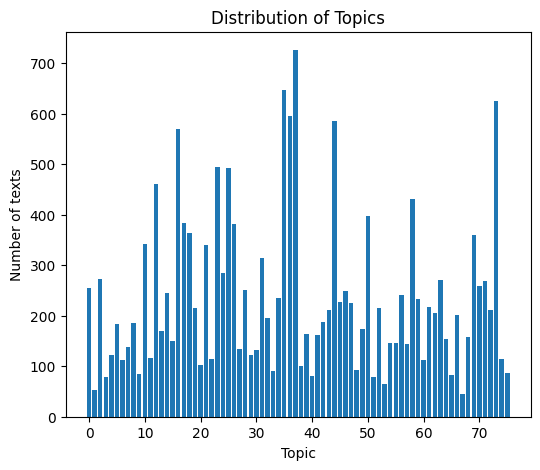

In [200]:
# Get emotion counts
counts_ = document_topic_df['best_topic'].value_counts()

# Create bar plot
plt.figure(figsize=(6, 5))
plt.bar(counts_.index, counts_.values)
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of texts')

In [201]:
log_perplexity = lda_model.log_perplexity(bow_corpus) # Получаем логарифм perplexity
perplexity = pow(2, -log_perplexity)  # Вычисляем perplexity (основание 2)
#ИЛИ:
# perplexity = np.exp(-log_perplexity) #Если вы хотите использовать основание e (натуральный логарифм)
print("Perplexity:", perplexity)

Perplexity: 258.01655450959703


In [202]:
# !pip install pyLDAvis

In [203]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

In [204]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(76))

In [205]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

In [206]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(88) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
42     0.050582 -0.041771       1        1  2.333054
27    -0.331069 -0.060343       2        1  2.068320
5      0.048736 -0.064412       3        1  2.015250
71    -0.082594  0.235424       4        1  1.942153
66     0.035256  0.059276       5        1  1.889607
...         ...       ...     ...      ...       ...
15    -0.186073 -0.149626      72        1  0.857725
63     0.043985  0.028640      73        1  0.848311
6      0.054139 -0.042808      74        1  0.794874
30    -0.200373 -0.017940      75        1  0.721099
43     0.045952  0.034427      76        1  0.696645

[76 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
28       'росс',  1309.000000  1309.000000  Default  30.0000  30.0000
899       'всу',   894.000000   894.000000  Default  29.0000  29.0000
1193     'атак',   817.000000   817.000000  Default  28.0000  28.0000
658    'област',  1777.000000  1777.000000  Default  27.0000  27.0000
89      'сообщ',  1045.000000  1045.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
9      'призна',     0.017721    96.067197  Topic76 -10.5546  -3.6314
10    'вариант',     0.017721    67.120614  Topic76 -10.5546  -3.2729
11       'прот',     0.017721   347.421011  Topic76 -10.5546  -4.9169
12      'путин',     0.017721   301.608786  Topic76 -10.5546  -4.7755
13      'санкц',     0.017721   177.166609  Topic76 -10.5546  -4.2435

[3012 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1453     57  0.969480    'abrams',
1451     49  0.983149    'atacms',
1360     32  0.992712         'f',
1135     49  0.978091         'f']
139      11  0.975042         'g',
...     ...       ...          ...
544      56  0.962930  ['швейцар',
1452     72  0.925102  ['шебекин',
1130     66  0.983516     ['шойг',
457      22  0.989312    ['шольц',
883      53  0.979113   ['эрдога',

[1597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[43, 28, 6, 72, 67, 41, 53, 11, 17, 68, 22, 13, 24, 59, 75, 29, 73, 30, 4, 58, 36, 50, 49, 51, 26, 27, 76, 46, 3, 56, 47, 74, 42, 61, 1, 54, 9, 32, 18, 69, 10, 14, 60, 34, 45, 12, 55, 63, 71, 33, 15, 21, 35, 2, 57, 37, 23, 19, 38, 52, 66, 65, 5, 8, 48, 25, 62, 39, 70, 40, 20, 16, 64, 7, 31, 44])